In [1]:
import os
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision.transforms as transforms
import pandas as pd

In [2]:

def save_magnetogram_images(base_dir, output_dir):
    # Ensure the output directory exists
    if not os.path.exists(output_dir):
        os.makedirs(output_dir)

    # Walk through all directories and subdirectories
    for root, dirs, files in os.walk(base_dir):
        magnetogram_files = [file for file in files if file.endswith("__magnetogram.jpg")]

        # Process each magnetogram file
        for file in magnetogram_files:
            file_path = os.path.join(root, file)

            # Load the image
            image = Image.open(file_path)
            image_array = np.array(image)

            # Create specific output directory within the output directory
            path_parts = root.split(os.sep)
            if len(path_parts) > 2:
                parent_folder_name = path_parts[-2]  # Parent folder
                current_folder_name = path_parts[-1]  # Current folder
                specific_output_dir = os.path.join(output_dir, parent_folder_name, current_folder_name)
                
                if not os.path.exists(specific_output_dir):
                    os.makedirs(specific_output_dir)

                # Save the image in the output directory
                output_path = os.path.join(specific_output_dir, file)
                image.save(output_path)  # Save the image directly

# Define your base and output directories
base_directory = r'C:\Users\purus\Documents\Chalmers\Advanced_ML\Project\SDOBenchmark-data-full\SDOBenchmark-data-full\training'
output_directory = r'C:\Users\purus\Documents\Chalmers\Advanced_ML\Project\SDOBenchmark-data-full\SDOBenchmark-data-full\magnetogram_image'

# Execute the function
save_magnetogram_images(base_directory, output_directory)


In [3]:
import numpy as np
import os
from PIL import Image
from torchvision import transforms

def convert_and_save_npz(base_dir, output_dir):
    transform = transforms.Compose([
        transforms.ToTensor(),
    ])
    
    for root, dirs, files in os.walk(base_dir):
        for file in files:
            if file.endswith("__magnetogram.jpg"):
                file_path = os.path.join(root, file)
                image = Image.open(file_path).convert('L')
                image_tensor = transform(image)
                
                # Prepare directories and paths
                relative_path = os.path.relpath(root, base_dir)
                save_dir = os.path.join(output_dir, relative_path)
                if not os.path.exists(save_dir):
                    os.makedirs(save_dir)
                
                tensor_filename = file.replace('.jpg', '.npz')
                tensor_save_path = os.path.join(save_dir, tensor_filename)
                
                # Convert tensor to numpy array and save as .npz with a named array
                np.savez_compressed(tensor_save_path, image_tensor=image_tensor.numpy())



# Example usage
base_directory =  r'C:\Users\purus\Documents\Chalmers\Advanced_ML\Project\SDOBenchmark-data-full\SDOBenchmark-data-full\magnetogram_image'
output_directory =  r'C:\Users\purus\Documents\Chalmers\Advanced_ML\Project\SDOBenchmark-data-full\SDOBenchmark-data-full\magnetogram_npz'


convert_and_save_npz(base_directory, output_directory)


In [7]:
from torch.utils.data import Dataset, DataLoader
import torch
import numpy as np
import os
output_directory = r'C:\Users\purus\Documents\Chalmers\Advanced_ML\Project\SDOBenchmark-data-full\SDOBenchmark-data-full\magnetogram_npz'


class NPZMagnetogramDataset(Dataset):
    def __init__(self, directory):
        self.samples = []
        # Walk through each directory and collect directories with exactly four .npz files
        for root, _, files in os.walk(directory):
            npz_files = [os.path.join(root, f) for f in files if f.endswith(".npz")]
            if len(npz_files) == 4:
                self.samples.append((sorted(npz_files), root))

    def __len__(self):
        return len(self.samples)

    def __getitem__(self, idx):
        file_paths, directory = self.samples[idx]
        # Load each tensor and stack them along a new dimension (0)
        tensors = torch.stack([torch.from_numpy(np.load(file)['image_tensor']) for file in file_paths])
        return tensors, directory
# DataLoader Setup
dataset = NPZMagnetogramDataset(output_directory)
dataloader = DataLoader(dataset, batch_size=10, shuffle=True)  # Adjust based on your system capabilities

print('dataloaded!')

for sequence, directory in dataloader:
    print(f"Loaded from {directory}")
    print(sequence.shape)  # Expected shape: [batch_size, seq_len, channels, height, width]
    break





dataloaded!
Loaded from ('C:\\Users\\purus\\Documents\\Chalmers\\Advanced_ML\\Project\\SDOBenchmark-data-full\\SDOBenchmark-data-full\\magnetogram_npz\\11560\\2012_09_01_18_10_01_0', 'C:\\Users\\purus\\Documents\\Chalmers\\Advanced_ML\\Project\\SDOBenchmark-data-full\\SDOBenchmark-data-full\\magnetogram_npz\\12681\\2017_09_29_14_34_00_1', 'C:\\Users\\purus\\Documents\\Chalmers\\Advanced_ML\\Project\\SDOBenchmark-data-full\\SDOBenchmark-data-full\\magnetogram_npz\\12436\\2015_10_18_12_00_00_0', 'C:\\Users\\purus\\Documents\\Chalmers\\Advanced_ML\\Project\\SDOBenchmark-data-full\\SDOBenchmark-data-full\\magnetogram_npz\\12203\\2014_11_02_21_25_00_2', 'C:\\Users\\purus\\Documents\\Chalmers\\Advanced_ML\\Project\\SDOBenchmark-data-full\\SDOBenchmark-data-full\\magnetogram_npz\\11806\\2013_07_28_18_27_00_5', 'C:\\Users\\purus\\Documents\\Chalmers\\Advanced_ML\\Project\\SDOBenchmark-data-full\\SDOBenchmark-data-full\\magnetogram_npz\\11486\\2012_05_19_12_00_00_14', 'C:\\Users\\purus\\Documen

In [5]:
import os

def check_npz_file_count(base_dir):
    # Walk through all directories in the base directory
    num_full_data=0
    num_not_full=0
    for root, dirs, files in os.walk(base_dir):
        for dir in dirs:
            dir_path = os.path.join(root, dir)
            # Get all npz files in the current directory
            npz_files = [file for file in os.listdir(dir_path) if file.endswith('.npz')]
            # Check if the number of npz files is exactly four
            if len(npz_files) != 4:
                num_not_full+=1
                # print(f"Directory {dir_path} does not have 4 npz files, it has {len(npz_files)} files.")
            else:
                num_full_data +=1
                # print(f"Directory {dir_path} has exactly 4 npz files.")
    print(num_full_data,num_not_full)

# Define the base directory path

# Call the function
check_npz_file_count(output_directory)

7746 1679


In [6]:
meta_data = pd.read_csv(r"C:\Users\purus\Documents\Chalmers\Advanced_ML\Project\SDOBenchmark-data-full\SDOBenchmark-data-full\training\meta_data.csv")
print(meta_data.columns)

Index(['id', 'start', 'end', 'peak_flux'], dtype='object')


In [8]:
import os
import numpy as np
import torch
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms

class SolarImagesDataset(Dataset):
    def __init__(self, root_dir, transform=None):
        """
        Args:
            root_dir (string): Path to the directory with all the `.npz` files.
            transform (callable, optional): Optional transform to be applied on a sample.
        """
        self.root_dir = root_dir
        self.transform = transform
        self.file_names = []
        # Recursively walk through all subdirectories to find .npz files
        for subdir, dirs, files in os.walk(root_dir):
            for file in files:
                if file.endswith('.npz'):
                    self.file_names.append(os.path.join(subdir, file))

    def __len__(self):
        return len(self.file_names)

    def __getitem__(self, idx):
        # Load the image
        file_path = self.file_names[idx]
        data = np.load(file_path)
        image = data['image_tensor']  # Ensure you use the correct key here
        image = torch.from_numpy(image).float()

        # Apply transformation
        if self.transform:
            image = self.transform(image)

        # Generate a positive pair (augmentation of the same image)
        pos_image = self.transform(image) if self.transform else image

        # Select a random image for a negative pair
        neg_idx = np.random.randint(0, len(self.file_names))
        while neg_idx == idx:
            neg_idx = np.random.randint(0, len(self.file_names))
        neg_file_path = self.file_names[neg_idx]
        neg_data = np.load(neg_file_path)
        neg_image = neg_data['image_tensor']  # Ensure you use the correct key here
        neg_image = torch.from_numpy(neg_image).float()
        neg_image = self.transform(neg_image) if self.transform else neg_image

        return image, pos_image, neg_image

# Setup transformations
transform = transforms.Compose([
    transforms.ToPILImage(),
    transforms.RandomHorizontalFlip(),
    transforms.RandomVerticalFlip(),
    transforms.ToTensor(),
])



# Create dataset
path_to_npz =r'C:\Users\purus\Documents\Chalmers\Advanced_ML\Project\SDOBenchmark-data-example\SDOBenchmark-data-example\magentogram_npz1'
dataset = SolarImagesDataset(root_dir=path_to_npz, transform=transform)

# DataLoader
data_loader = DataLoader(dataset, batch_size=20, shuffle=True)


In [3]:
import os
import numpy as np
import torch
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
import pandas as pd
import torch
from torch.utils.data import DataLoader, random_split

class SolarImagesDataset(Dataset):
    def __init__(self, metadata_file, root_dir, transform=None):
        """
        Args:
            metadata_file (string): Path to the metadata CSV file containing 'id', 'peak_flux', and other info.
            root_dir (string): Path to the directory with all the `.npz` files (base directory before the subfolders).
            transform (callable, optional): Optional transform to be applied on a sample.
        """
        self.root_dir = root_dir
        self.transform = transform
        self.meta_data = pd.read_csv(metadata_file)
        self.file_names = []  # List to store file paths
        self.peak_fluxes = []  # List to store peak flux values
        self.paths = []  # List to store complete paths for returning

        # Loop through each entry in the metadata
        for index, row in self.meta_data.iterrows():
            sequence_id = row['id']
            sequence_path = os.path.join(self.root_dir, sequence_id.split('_')[0], '_'.join(sequence_id.split('_')[1:]))
            try:
                # Read all .npz files in the final folder
                if os.path.isdir(sequence_path):
                    for file in sorted(os.listdir(sequence_path)):
                        if file.endswith('.npz'):
                            full_path = os.path.join(sequence_path, file)
                            self.file_names.append(full_path)
                            self.peak_fluxes.append(row['peak_flux'])
                            self.paths.append(sequence_path)
                            # self.paths.append(sequence_path.replace("\\", "\"))
            except FileNotFoundError:
                continue

    def __len__(self):
        return len(self.file_names)

    def __getitem__(self, idx):
        file_path = self.file_names[idx]
        data = np.load(file_path)
        image = data['image_tensor']  # Adjust the key as necessary
        image = torch.from_numpy(image).float()

        if self.transform:
            image = self.transform(image)

        # Generate a positive pair (augmentation of the same image)
        pos_image = self.transform(image) if self.transform else image

        # Select a random image for a negative pair
        neg_idx = np.random.randint(0, len(self.file_names))
        while neg_idx == idx:
            neg_idx = np.random.randint(0, len(self.file_names))
        neg_file_path = self.file_names[neg_idx]
        neg_data = np.load(neg_file_path)
        neg_image = neg_data['image_tensor']  # Adjust the key as necessary
        neg_image = torch.from_numpy(neg_image).float()
        neg_image = self.transform(neg_image) if self.transform else neg_image

        return image, pos_image, neg_image, self.peak_fluxes[idx], self.paths[idx]

# Setup transformations
transform = transforms.Compose([
    transforms.ToPILImage(),
    transforms.RandomHorizontalFlip(),
    transforms.RandomVerticalFlip(),
    transforms.ToTensor(),
])

# Example of usage
metadata_file = r"C:\Users\purus\Documents\Chalmers\Advanced_ML\Project\SDOBenchmark-data-full\SDOBenchmark-data-full\training\meta_data.csv"
root_dir = r'C:\Users\purus\Documents\Chalmers\Advanced_ML\Project\SDOBenchmark-data-full\SDOBenchmark-data-full\magnetogram_npz'
dataset = SolarImagesDataset(metadata_file=metadata_file, root_dir=root_dir, transform=transform)
# data_loader = DataLoader(dataset, batch_size=32, shuffle=True)

train_size = int(0.8 * len(dataset))
val_size = len(dataset) - train_size

train_size = int(0.8 * len(dataset))
val_size = len(dataset) - train_size

# Split the dataset
train_dataset, val_dataset = random_split(dataset, [train_size, val_size])

# Define batch size
batch_size = 32

# Create DataLoaders
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)

# Verify by iterating through a batch
train_iter = iter(train_loader)
val_iter = iter(val_loader)

train_batch = next(train_iter)
val_batch = next(val_iter)

print(f'Training batch shape: {train_batch[0].shape}')
print(f'Validation batch shape: {val_batch[0].shape}')

Training batch shape: torch.Size([32, 1, 256, 256])
Validation batch shape: torch.Size([32, 1, 256, 256])


Batch 1
Original Image Shape: torch.Size([32, 1, 256, 256])
Positive Image Shape: torch.Size([32, 1, 256, 256])
Negative Image Shape: torch.Size([32, 1, 256, 256])
 peak tensor([8.1176e-07, 1.1176e-06, 4.9412e-07, 1.0000e-09, 2.1176e-07, 1.0000e-09,
        6.1176e-06, 7.4118e-07, 1.6471e-06, 1.0000e-09, 8.1176e-07, 1.1412e-06,
        1.0000e-09, 1.0000e-09, 1.0000e-09, 1.0000e-09, 2.7059e-06, 3.4118e-06,
        1.6471e-06, 2.8235e-06, 1.1765e-05, 1.0000e-09, 7.6471e-05, 1.0000e-09,
        3.0588e-07, 1.5294e-06, 3.5294e-07, 1.4118e-06, 1.0000e-09, 1.6471e-06,
        2.8235e-06, 2.7059e-07], dtype=torch.float64)
path ('C:\\Users\\purus\\Documents\\Chalmers\\Advanced_ML\\Project\\SDOBenchmark-data-full\\SDOBenchmark-data-full\\magnetogram_npz\\11696\\2013_03_16_00_54_01_1', 'C:\\Users\\purus\\Documents\\Chalmers\\Advanced_ML\\Project\\SDOBenchmark-data-full\\SDOBenchmark-data-full\\magnetogram_npz\\11460\\2012_04_24_08_57_01_0', 'C:\\Users\\purus\\Documents\\Chalmers\\Advanced_ML\\P

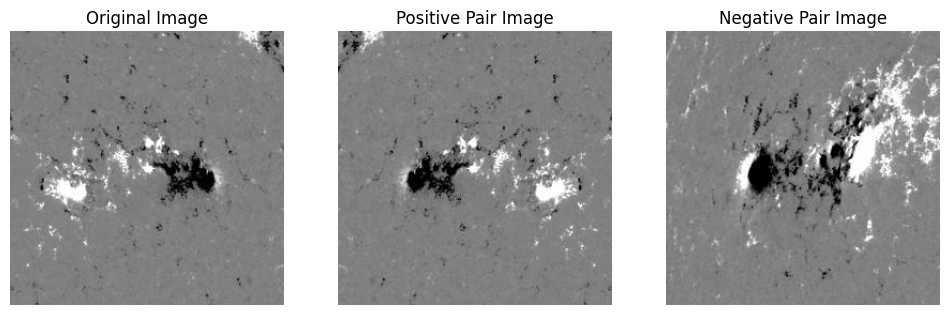

In [4]:
import matplotlib.pyplot as plt

def show_image(img):
    """Utility function to display a tensor as an image."""
    img = img.numpy()
    plt.imshow(np.transpose(img, (1, 2, 0)),cmap='gray')  # Transform the tensor to HWC
    plt.axis('off')  # Turn off axis numbers and ticks

# Assuming you have a data_loader as previously defined
for i, data in enumerate(train_loader, start=1):
    original_image, positive_image, negative_image, peak, path = data

    print(f"Batch {i}")
    print(f"Original Image Shape: {original_image.shape}")
    print(f"Positive Image Shape: {positive_image.shape}")
    print(f"Negative Image Shape: {negative_image.shape}")
    print(f' peak {peak}')
    print(f'path {path}')
    # Optionally visualize the first set in the batch
    if i == 1:  # Just display images from the first batch
        plt.figure(figsize=(12, 4))
        plt.subplot(1, 3, 1)
        show_image(original_image[0])  # Show the first image
        plt.title('Original Image')

        plt.subplot(1, 3, 2)
        show_image(positive_image[0])  # Show the first positive pair image
        plt.title('Positive Pair Image')

        plt.subplot(1, 3, 3)
        show_image(negative_image[0])  # Show the first negative pair image
        plt.title('Negative Pair Image')

        plt.show()

    if i >= 1:  # Break after inspecting the first batch
        break


In [12]:
import torch
import torch.nn as nn

class SimpleCNN(nn.Module):
    def __init__(self):
        super(SimpleCNN, self).__init__()
        self.conv_layers = nn.Sequential(
            nn.Conv2d(1, 32, kernel_size=3, stride=1, padding=1),  # Adjust the channel number based on your input
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2),
            nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2),
            nn.Conv2d(64, 128, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2),
        )
        self.fc_layers = nn.Sequential(
            nn.Flatten(),
            nn.Linear(128 * 32 * 32, 256),  # Adjust the sizing according to your image dimensions after pooling
            nn.ReLU(),
            nn.Linear(256, 128)
        )

    def forward(self, x):
        x = self.conv_layers(x)
        x = self.fc_layers(x)
        return x
import torch
import torch.nn as nn

class EnhancedCNN(nn.Module):
    def __init__(self):
        super(EnhancedCNN, self).__init__()
        self.conv_layers = nn.Sequential(
            nn.Conv2d(1, 32, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(32),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2),
            nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2),
            nn.Conv2d(64, 128, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2),
            nn.Conv2d(128, 256, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2),
        )
        self.fc_layers = nn.Sequential(
            nn.Flatten(),
            nn.Linear(256 * 16 * 16, 512), 
            nn.ReLU(),
            nn.Dropout(0.5),
            nn.Linear(512, 128),
            nn.Dropout(0.5)
        )

    def forward(self, x):
        x = self.conv_layers(x)
        x = self.fc_layers(x)
        return x

model = EnhancedCNN()
print(model)




EnhancedCNN(
  (conv_layers): Sequential(
    (0): Conv2d(1, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (4): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (5): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (6): ReLU()
    (7): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (8): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (9): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (10): ReLU()
    (11): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (12): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=

In [13]:
class ContrastiveLoss(nn.Module):
    def __init__(self, margin=1.0):
        super(ContrastiveLoss, self).__init__()
        self.margin = margin
        self.cos = nn.CosineSimilarity(dim=1)
        self.relu = nn.ReLU()

    def forward(self, output1, output2, negative):
        # Calculating the cosine similarity for positive and negative pairs
        pos_similarity = self.cos(output1, output2)  # Closer to 1 is better
        neg_similarity = self.cos(output1, negative)  # Closer to -1 is better

        # Calculating losses for positive and negative pairs
        pos_loss = 1 - pos_similarity  # Loss for positive pair
        neg_loss = self.relu(neg_similarity - self.margin)  # Loss for negative pair; should be less than margin

        # Combine losses: Simple average or a more sophisticated reduction
        loss = (pos_loss + neg_loss).mean()  # Ensure reduction to scalar
        return loss


In [89]:
import torch.optim as optim

# Assuming you have a DataLoader that provides batches in the form of (original_image, positive_image, negative_image, flux_values, paths)
optimizer = optim.Adam(model.parameters(), lr=0.001)
criterion = ContrastiveLoss(margin=0.5)
device ='cuda'
model = model.to(device)
def train_model(model, data_loader, optimizer, criterion, num_epochs=15):
    model.train()  # Set model to training mode

    for epoch in range(num_epochs):
        total_loss = 0
        for i,batch in enumerate (data_loader):
            original_image, positive_image, negative_image, _, _ = batch
            original_image, positive_image, negative_image = original_image.float().to(device), positive_image.float().to(device), negative_image.float().to(device)

            optimizer.zero_grad()

            # Compute embeddings
            orig_emb = model(original_image)
            pos_emb = model(positive_image)
            neg_emb = model(negative_image)

            # Compute contrastive loss
            loss = criterion(orig_emb, pos_emb, neg_emb)
            loss.backward()
            optimizer.step()

            total_loss += loss.item()
            print(f'Epoch {epoch+1}/{num_epochs}, Batch {i+1}/{len(data_loader)}', end='\r')
        avg_loss = total_loss / len(data_loader)
        print(f'Epoch [{epoch + 1}/{num_epochs}], Loss: {avg_loss:.4f}')

train_model(model, data_loader, optimizer, criterion)


Epoch [1/15], Loss: 0.52671
Epoch [2/15], Loss: 0.52411
Epoch [3/15], Loss: 0.52331
Epoch [4/15], Loss: 0.52301
Epoch [5/15], Loss: 0.52381
Epoch [6/15], Loss: 0.52311
Epoch [7/15], Loss: 0.52261
Epoch [8/15], Loss: 0.52261
Epoch [9/15], Loss: 0.52381
Epoch [10/15], Loss: 0.52321
Epoch [11/15], Loss: 0.51691
Epoch [12/15], Loss: 0.51191
Epoch [13/15], Loss: 0.51061
Epoch [14/15], Loss: 0.50941
Epoch [15/15], Loss: 0.50891


In [15]:
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import DataLoader

# Assuming you have already defined the DataLoaders
# train_loader = ...
# val_loader = ...

optimizer = optim.Adam(model.parameters(), lr=0.001)
criterion = ContrastiveLoss(margin=0.5)
device = 'cuda' if torch.cuda.is_available() else 'cpu'
model = model.to(device)
print(device)
def train_model(model, train_loader, val_loader, optimizer, criterion, num_epochs=30):
    for epoch in range(num_epochs):
        model.train()  # Set model to training mode
        total_loss = 0

        # Training loop
        for i, batch in enumerate(train_loader):
            original_image, positive_image, negative_image, _, _ = batch
            original_image, positive_image, negative_image = original_image.float().to(device), positive_image.float().to(device), negative_image.float().to(device)

            optimizer.zero_grad()

            # Compute embeddings
            orig_emb = model(original_image)
            pos_emb = model(positive_image)
            neg_emb = model(negative_image)

            # Compute contrastive loss
            loss = criterion(orig_emb, pos_emb, neg_emb)
            loss.backward()
            optimizer.step()

            total_loss += loss.item()
            print(f'Epoch {epoch+1}/{num_epochs}, Batch {i+1}/{len(train_loader)}', end='\r')

        avg_loss = total_loss / len(train_loader)
        # print(f'Epoch [{epoch + 1}/{num_epochs}], Training Loss: {avg_loss:.4f}')

        # Validation loop
        model.eval()  # Set model to evaluation mode
        val_loss = 0
        with torch.no_grad():
            for batch in val_loader:
                original_image, positive_image, negative_image, _, _ = batch
                original_image, positive_image, negative_image = original_image.float().to(device), positive_image.float().to(device), negative_image.float().to(device)

                # Compute embeddings
                orig_emb = model(original_image)
                pos_emb = model(positive_image)
                neg_emb = model(negative_image)

                # Compute contrastive loss
                loss = criterion(orig_emb, pos_emb, neg_emb)
                val_loss += loss.item()

        avg_val_loss = val_loss / len(val_loader)
        print(f'Epoch [{epoch + 1}/{num_epochs}],Training Loss: {avg_loss:.4f}; Validation Loss: {avg_val_loss:.4f}')

train_model(model, train_loader, val_loader, optimizer, criterion)


cuda
Epoch [1/30],Training Loss: 0.5248; Validation Loss: 0.4997
Epoch [2/30],Training Loss: 0.5211; Validation Loss: 0.3991
Epoch [3/30],Training Loss: 0.5144; Validation Loss: 0.3092
Epoch [4/30],Training Loss: 0.5123; Validation Loss: 0.2849
Epoch [5/30],Training Loss: 0.5120; Validation Loss: 0.2903
Epoch [6/30],Training Loss: 0.5113; Validation Loss: 0.2760
Epoch [7/30],Training Loss: 0.5113; Validation Loss: 0.2711
Epoch [8/30],Training Loss: 0.5112; Validation Loss: 0.2705
Epoch [9/30],Training Loss: 0.5110; Validation Loss: 0.2683
Epoch [10/30],Training Loss: 0.5102; Validation Loss: 0.2544
Epoch [11/30],Training Loss: 0.5097; Validation Loss: 0.2559
Epoch [12/30],Training Loss: 0.5091; Validation Loss: 0.2440
Epoch [13/30],Training Loss: 0.5086; Validation Loss: 0.2185
Epoch [14/30],Training Loss: 0.5089; Validation Loss: 0.1996
Epoch [15/30],Training Loss: 0.5088; Validation Loss: 0.2145
Epoch [16/30],Training Loss: 0.5079; Validation Loss: 0.2016
Epoch [17/30],Training Loss:

In [16]:
torch.save(model.state_dict(), 'cnn_weights_with_validation.pth')
print("Model saved successfully!")


Model saved successfully!


In [25]:
device='cuda'

model= model.to(device)
model.load_state_dict(torch.load('cnn_weights_with_validation.pth'))
model.eval()
print("Model parameters loaded successfully and model is ready to make predictions!")


Model parameters loaded successfully and model is ready to make predictions!


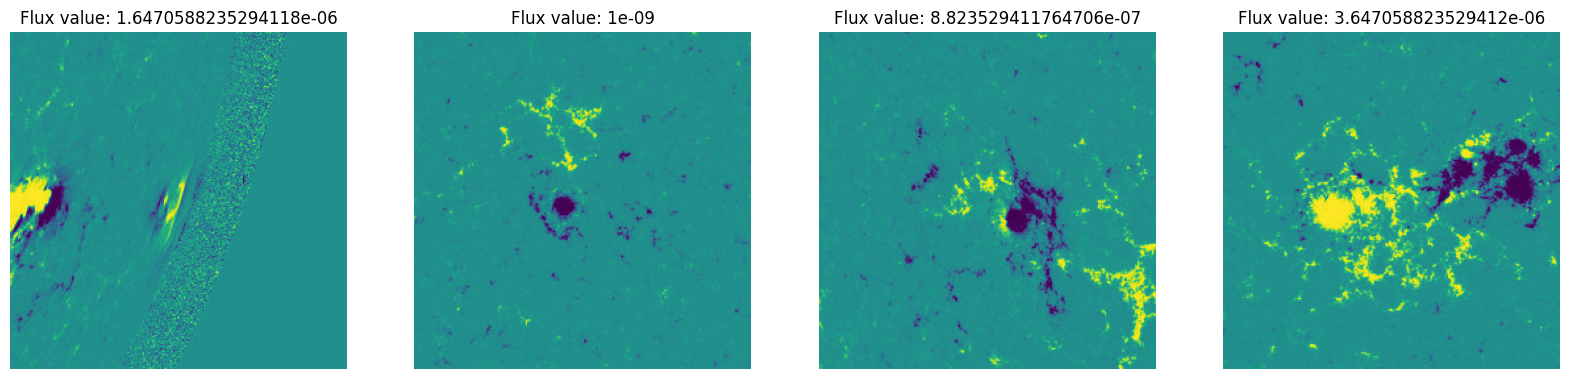

('C:\\Users\\purus\\Documents\\Chalmers\\Advanced_ML\\Project\\SDOBenchmark-data-full\\SDOBenchmark-data-full\\magnetogram_npz\\12226\\2014_12_06_09_19_01_0', 'C:\\Users\\purus\\Documents\\Chalmers\\Advanced_ML\\Project\\SDOBenchmark-data-full\\SDOBenchmark-data-full\\magnetogram_npz\\11546\\2012_08_21_10_06_00_1', 'C:\\Users\\purus\\Documents\\Chalmers\\Advanced_ML\\Project\\SDOBenchmark-data-full\\SDOBenchmark-data-full\\magnetogram_npz\\12394\\2015_08_07_18_19_00_0', 'C:\\Users\\purus\\Documents\\Chalmers\\Advanced_ML\\Project\\SDOBenchmark-data-full\\SDOBenchmark-data-full\\magnetogram_npz\\12002\\2014_03_14_00_26_01_0')


In [44]:
def plot_image_flux(images, flux):
    fig, axs = plt.subplots(1, 4, figsize=(20, 5)) 
    for i in range(4):
        img = images[i].squeeze()
        axs[i].imshow(img)
        axs[i].axis('off')
        axs[i].set_title(f'Flux value: {flux[i]}')
    plt.show()

def extract_embeddings_and_labels(model, data_loader):
    model.eval()
    embeddings = []
    flux_values = []
    with torch.no_grad():
        for images, _, _, flux, path in data_loader:
            images = images.float().to(device) 
            emb = model(images).cpu().numpy()  
            embeddings.append(emb)
            flux_values.extend(flux.numpy())  
    plot_image_flux(images.cpu(),flux)
    print(path[:4])
    embeddings = np.vstack(embeddings)  
    flux_values = np.array(flux_values)  
    return embeddings, flux_values

embeddings, flux_values = extract_embeddings_and_labels(model, train_loader)


In [60]:
# flare_classes = np.zeros(flux_values.shape, dtype=int)

# # Assign class labels based on flux thresholds
# flare_classes[flux_values < 1e-6] = 0  # Class B
# flare_classes[(flux_values >= 1e-6) & (flux_values < 1e-5)] = 1  # Class C
# flare_classes[(flux_values >= 1e-5) & (flux_values < 1e-4)] = 2  # Class M
# flare_classes[flux_values >= 1e-4] = 3  # Class X
# count0, count1,count2, count3 =0,0,0,0
# for item in y_test:
#     if item ==0:
#         count0+=1
#     elif item ==1:
#         count1+=1
#     elif item ==2:
#         count2+=1
#     elif item ==3:
#         count3+=1
# print(count0, count1,count2, count3)


5816 3402 552 29


In [58]:
# from sklearn.ensemble import RandomForestClassifier
# from sklearn.metrics import classification_report, confusion_matrix
# from sklearn.model_selection import train_test_split
# from sklearn.preprocessing import StandardScaler

# # Assuming X_embeddings and y_flare_classes are your features and labels

# # Split the dataset into training and testing sets
# X_train, X_test, y_train, y_test = train_test_split(embeddings, flare_classes, test_size=0.3, random_state=42)

# # Standardize the features
# scaler = StandardScaler()
# X_train_scaled = scaler.fit_transform(X_train)
# X_test_scaled = scaler.transform(X_test)

# # Initialize and train the Random Forest model with class weights
# rf_model = RandomForestClassifier(n_estimators=100, class_weight='balanced', random_state=42)
# rf_model.fit(X_train_scaled, y_train)

# # Predict on the test set
# y_pred = rf_model.predict(X_test_scaled)

# # Evaluate the model's performance
# print("Confusion Matrix:")
# print(confusion_matrix(y_test, y_pred))
# print("\nClassification Report:")
# print(classification_report(y_test, y_pred))


Confusion Matrix:
[[4965  824   24    3]
 [1694 1629   74    5]
 [ 214  251   80    7]
 [  10   17    2    0]]

Classification Report:
              precision    recall  f1-score   support

           0       0.72      0.85      0.78      5816
           1       0.60      0.48      0.53      3402
           2       0.44      0.14      0.22       552
           3       0.00      0.00      0.00        29

    accuracy                           0.68      9799
   macro avg       0.44      0.37      0.38      9799
weighted avg       0.66      0.68      0.66      9799



In [61]:
# cluster = rf_model.predict(embeddings)
# print(cluster)

[2 2 1 ... 2 2 1]


In [45]:
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA

# Using t-SNE
tsne = TSNE(n_components=2, perplexity=30, n_iter=300)
embeddings_2d_tsne = tsne.fit_transform(embeddings)

# Using PCA
pca = PCA(n_components=2)
embeddings_2d_pca = pca.fit_transform(embeddings)



In [46]:
from sklearn.cluster import KMeans

# Applying K-means clustering
kmeans = KMeans(n_clusters=4, random_state=0)
cluster_labels_tnse = kmeans.fit_predict(embeddings_2d_tsne) 
cluster_labels_pca = kmeans.fit_predict(embeddings_2d_pca)  

kmeans = KMeans(n_clusters=4, random_state=0)

cluster = kmeans.fit_predict(embeddings)

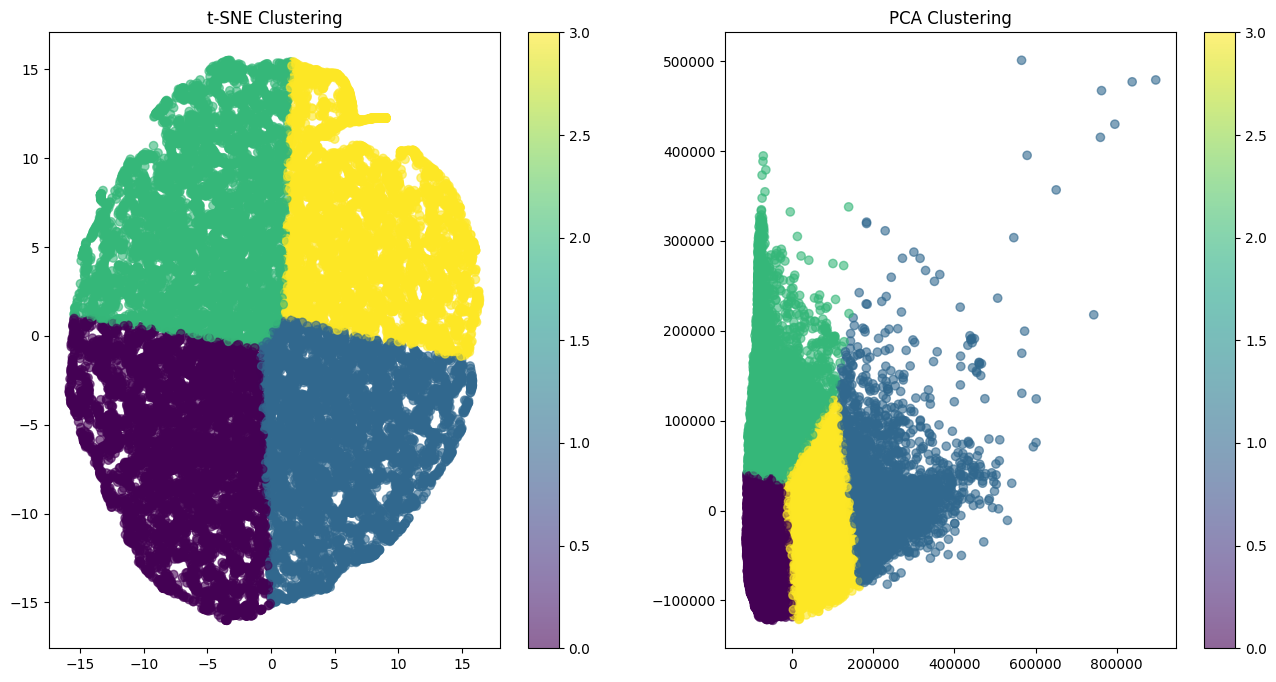

In [47]:
import matplotlib.pyplot as plt

plt.figure(figsize=(16, 8))

# Plot t-SNE results
plt.subplot(1, 2, 1)
scatter = plt.scatter(embeddings_2d_tsne[:, 0], embeddings_2d_tsne[:, 1], c=cluster_labels_tnse, cmap='viridis', alpha=0.6)
plt.colorbar(scatter)
plt.title('t-SNE Clustering')

# Plot PCA results
plt.subplot(1, 2, 2)
scatter = plt.scatter(embeddings_2d_pca[:, 0], embeddings_2d_pca[:, 1], c=cluster_labels_pca, cmap='viridis', alpha=0.6)
plt.colorbar(scatter)
plt.title('PCA Clustering')

plt.show()


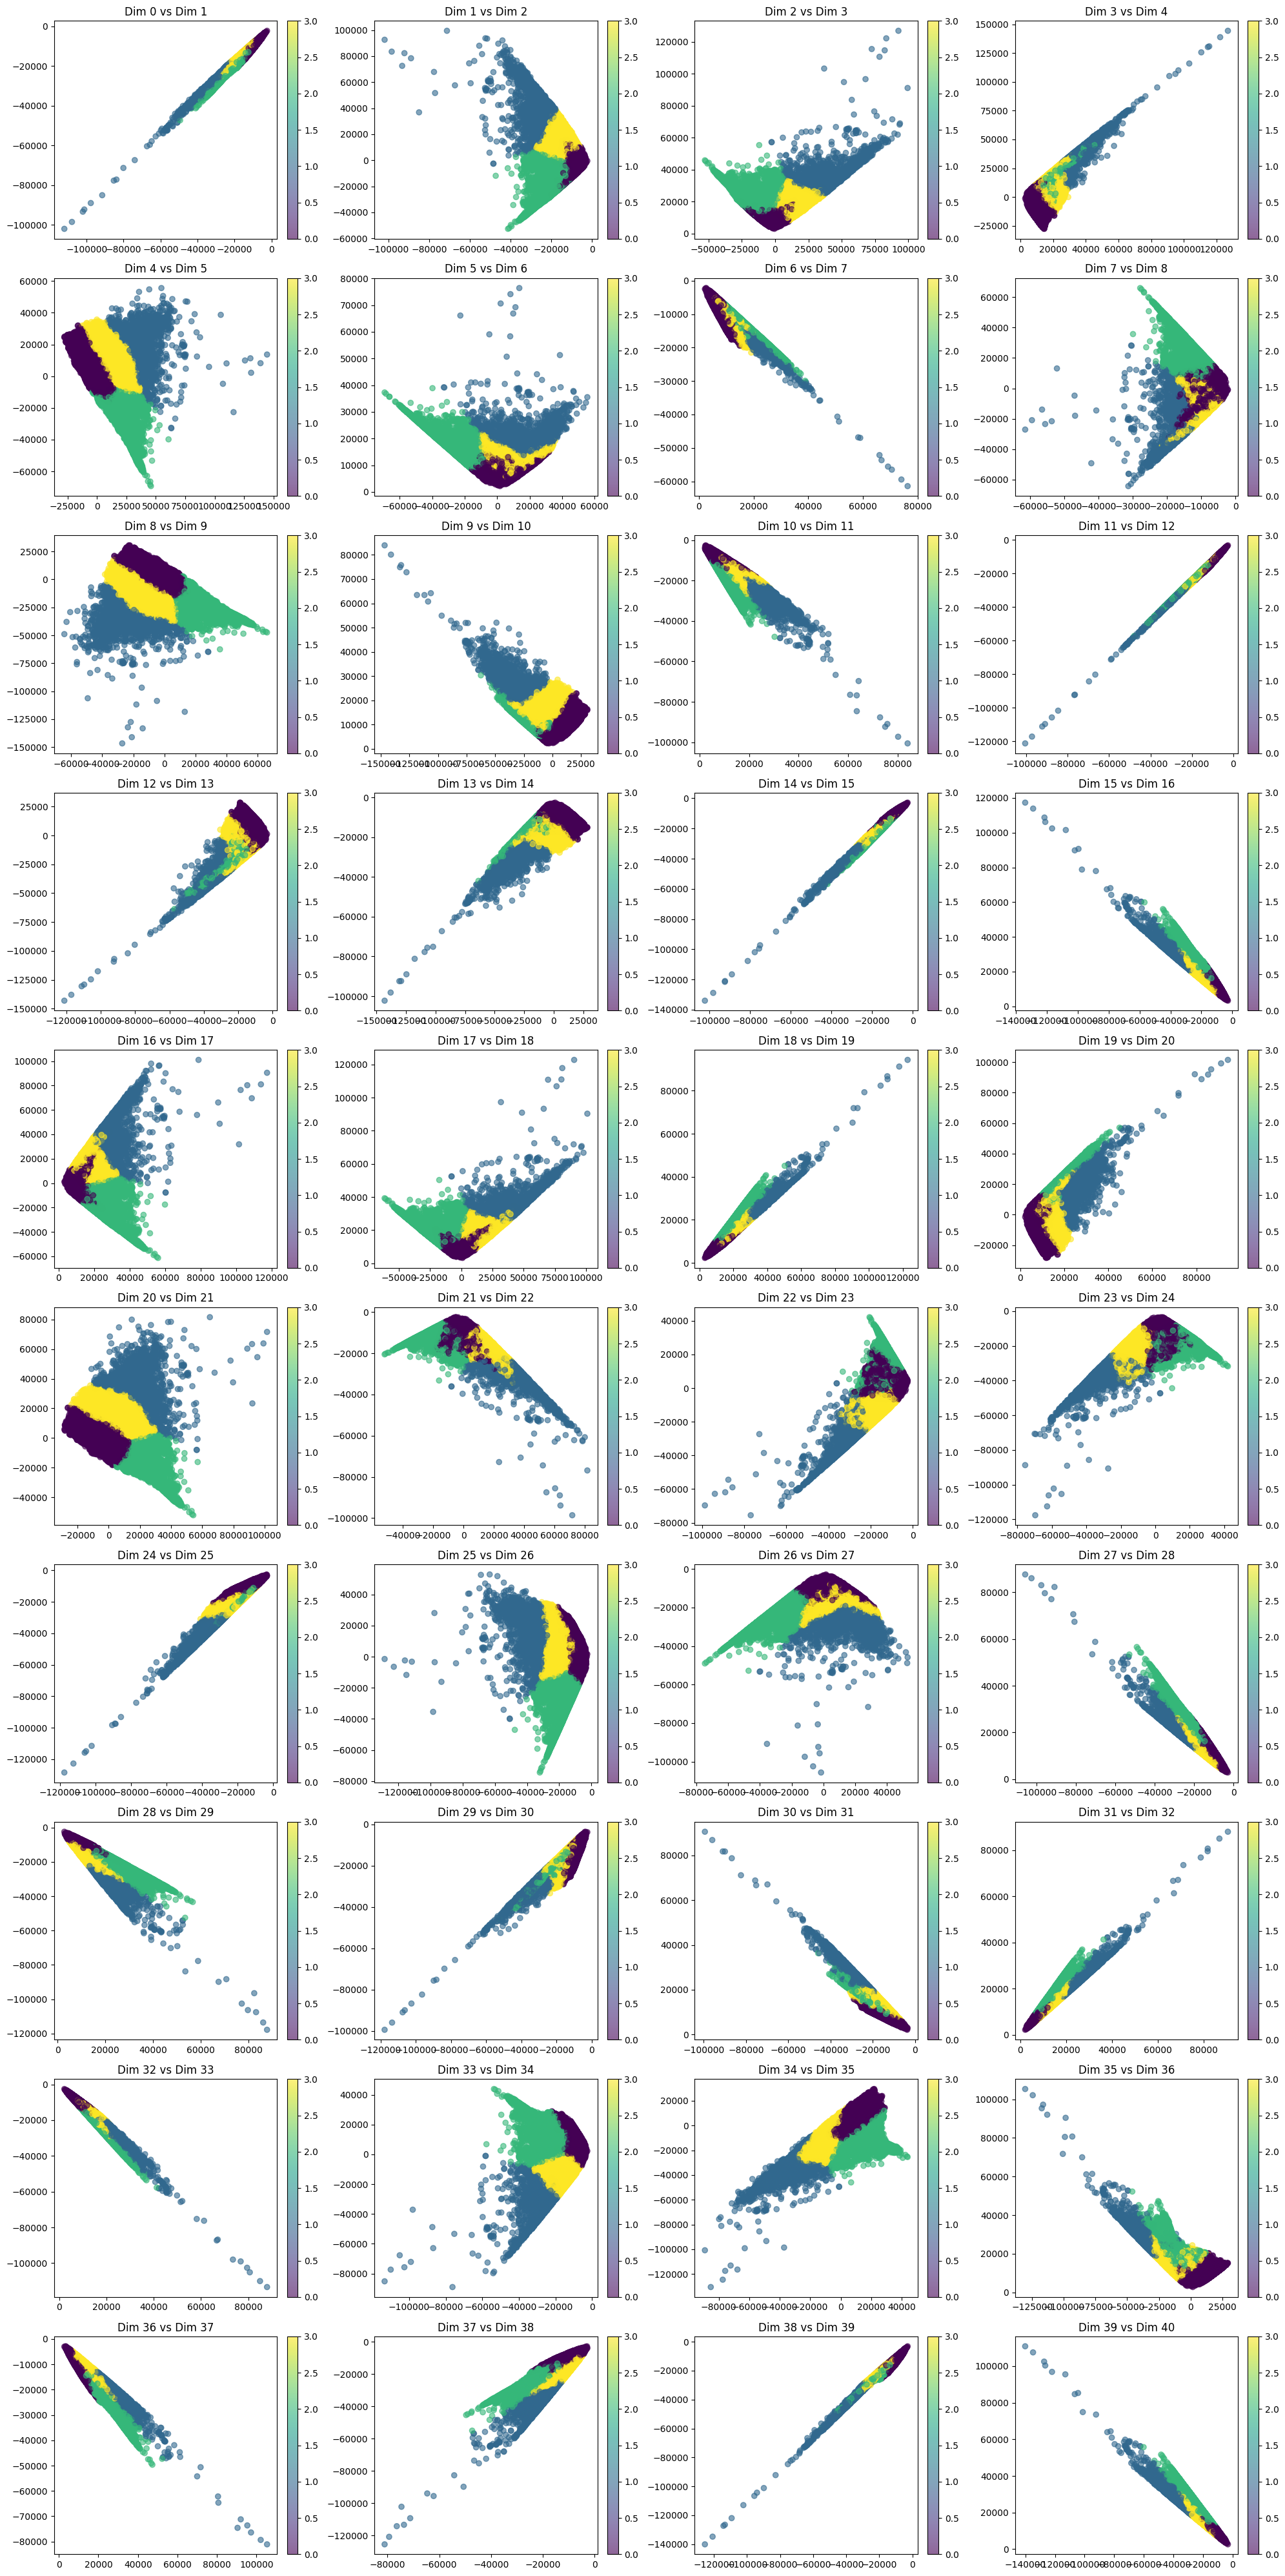

In [48]:
import matplotlib.pyplot as plt
import numpy as np

# Assume 'embeddings' is a Nx16 numpy array (or larger) and 'cluster' is an N-element array
# Let's generate some example data if you don't have these
# np.random.seed(0)
# embeddings = np.random.rand(100, 17)  # 100 points, 17 dimensions for demonstration
# cluster = np.random.randint(0, 4, 100)  # 100 points belonging to 4 clusters



plt.figure(figsize=(20, 40))  # Wider figure to accommodate 8 columns

for i in range(40):
    plt.subplot(10, 4, i + 1)  # 2 rows, 8 columns, current plot position i+1
    scatter = plt.scatter(embeddings[:, i], embeddings[:, i + 1], c=cluster, cmap='viridis', alpha=0.6)
    plt.colorbar(scatter, fraction=0.046, pad=0.04)  # Add a colorbar adjusted to fit the subplot
    plt.title(f'Dim {i} vs Dim {i+1}')  # Optional: Title to indicate which dimensions are being plotted

plt.tight_layout()  # Adjust layout to prevent overlap
plt.show()


In [32]:
# Define a flux threshold to categorize flares vs. no flares
flux_threshold = 1e-9
flare_labels = (flux_values > flux_threshold).astype(int)

from sklearn.metrics import confusion_matrix, accuracy_score

print("Confusion Matrix:\n", confusion_matrix(flare_labels, cluster_labels_tnse))
print("Accuracy of clustering vs. flux-based labels:", accuracy_score(flare_labels, cluster_labels_tnse))


NameError: name 'cluster_labels_tnse' is not defined

In [33]:
from sklearn.metrics import confusion_matrix, accuracy_score

def calculate_tss(conf_matrix):
    # Extracting TP, FN, FP, TN from the confusion matrix
    TP = conf_matrix[1, 1]
    FN = conf_matrix[1, 0]
    FP = conf_matrix[0, 1]
    TN = conf_matrix[0, 0]
    
    TPR = TP / (TP + FN) if (TP + FN) != 0 else 0
    FPR = FP / (FP + TN) if (FP + TN) != 0 else 0
    
    # TSS = TPR - FPR
    return TPR - FPR

# Compute confusion matrix
conf_matrix = confusion_matrix(flare_labels, cluster_labels_tnse)
tss_score = calculate_tss(conf_matrix)

print("Confusion Matrix:\n", conf_matrix)
print("Accuracy of clustering vs. flux-based labels:", accuracy_score(flare_labels, cluster_labels_tnse))
print("TSS Score:", tss_score)

import matplotlib.pyplot as plt
import seaborn as sns

def plot_confusion_matrix(cm, title='Confusion Matrix'):
    plt.figure(figsize=(6, 5))
    sns.heatmap(cm, annot=True, fmt="d", cmap='Blues')
    plt.title(title)
    plt.ylabel('Actual Label')
    plt.xlabel('Predicted Label')
    plt.show()

# Plotting the confusion matrix
plot_confusion_matrix(conf_matrix, title='Confusion Matrix with TSS Score: {:.3f}'.format(tss_score))


NameError: name 'cluster_labels_tnse' is not defined

Confusion Matrix:
 [[7369 4023 1448 2649]
 [2661 2615 1311 2404]
 [ 403  333  269  522]
 [  42   22   11   47]]
Accuracy of clustering vs. flux-based labels: 0.3941980175284167
TSS Score: 0.14249808066632025


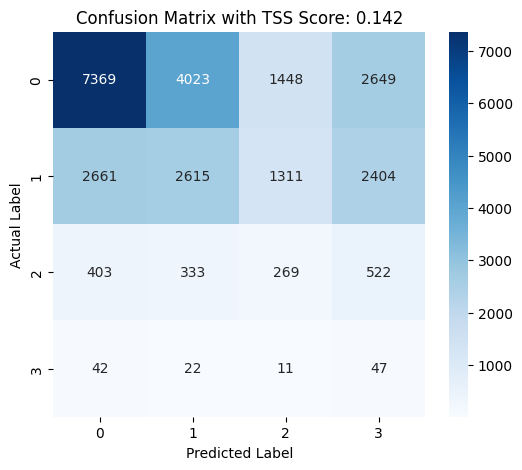

In [42]:
from sklearn.metrics import confusion_matrix, accuracy_score

# Initialize an array of zeros for class labels
flare_classes = np.zeros(flux_values.shape, dtype=int)

# Assign class labels based on flux thresholds
flare_classes[flux_values < 1e-6] = 0  # Class B
flare_classes[(flux_values >= 1e-6) & (flux_values < 1e-5)] = 1  # Class C
flare_classes[(flux_values >= 1e-5) & (flux_values < 1e-4)] = 2  # Class M
flare_classes[flux_values >= 1e-4] = 3  # Class X

conf_matrix= confusion_matrix(flare_classes, cluster)
print("Confusion Matrix:\n", conf_matrix)
print("Accuracy of clustering vs. flux-based labels:", accuracy_score(flare_classes, cluster))
# print(flare_classes)
tss_score = calculate_tss(conf_matrix)

# print("Confusion Matrix:\n", conf_matrix)
# print("Accuracy of clustering vs. flux-based labels:", accuracy_score(flare_labels, cluster_labels_tnse))
print("TSS Score:", tss_score)
import matplotlib.pyplot as plt
import seaborn as sns

def plot_confusion_matrix(cm, title='Confusion Matrix'):
    plt.figure(figsize=(6, 5))
    sns.heatmap(cm, annot=True, fmt="d", cmap='Blues')
    plt.title(title)
    plt.ylabel('Actual Label')
    plt.xlabel('Predicted Label')
    plt.show()

# Plotting the confusion matrix
plot_confusion_matrix(conf_matrix, title='Confusion Matrix with TSS Score: {:.3f}'.format(tss_score))


In [101]:
import numpy as np
from sklearn.cluster import KMeans
from sklearn.metrics import accuracy_score, confusion_matrix

def determine_cluster_labels(cluster_labels, true_labels):
    """
    Determine labels for clusters by matching the predominant true label in each cluster.
    This is a simple heuristic to assign the cluster label based on the most frequent true label.
    """
    predicted_labels = np.zeros_like(cluster_labels)
    for k in np.unique(cluster_labels):
        # Find indices where cluster label equals the current cluster
        indices = np.where(cluster_labels == k)
        # Assign the most common true label to these indices in predicted labels
        predicted_labels[indices] = np.bincount(true_labels[indices]).argmax()
    return predicted_labels

def perform_kmeans_and_evaluate(embeddings, flux_values, n_clusters=2):
    # Assuming binary classification based on flux value threshold
    flux_threshold = 1e-6
    binary_flux_labels = (flux_values > flux_threshold).astype(int)
    print(binary_flux_labels)

    # Perform K-means clustering
    kmeans = KMeans(n_clusters=n_clusters, random_state=42)
    cluster_labels = kmeans.fit_predict(embeddings)

    # Determine labels for each cluster
    predicted_labels = determine_cluster_labels(cluster_labels, binary_flux_labels)

    # Compute accuracy
    accuracy = accuracy_score(binary_flux_labels, predicted_labels)
    conf_matrix = confusion_matrix(binary_flux_labels, predicted_labels)

    print(f"Accuracy: {accuracy}")
    print(f"Confusion Matrix:\n{conf_matrix}")

# Call the function
perform_kmeans_and_evaluate(embeddings, flux_values)


[1 0 1 ... 0 0 1]
Accuracy: 0.675923091053824
Confusion Matrix:
[[17381  1970]
 [ 8615  4696]]


{'Class B': 649, 'Class C': 495, 'Class M': 160, 'Class X': 3}


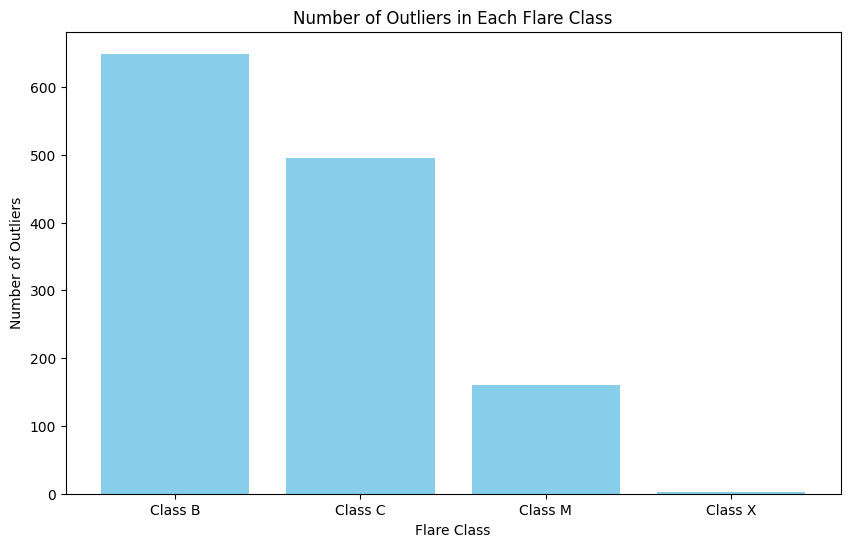

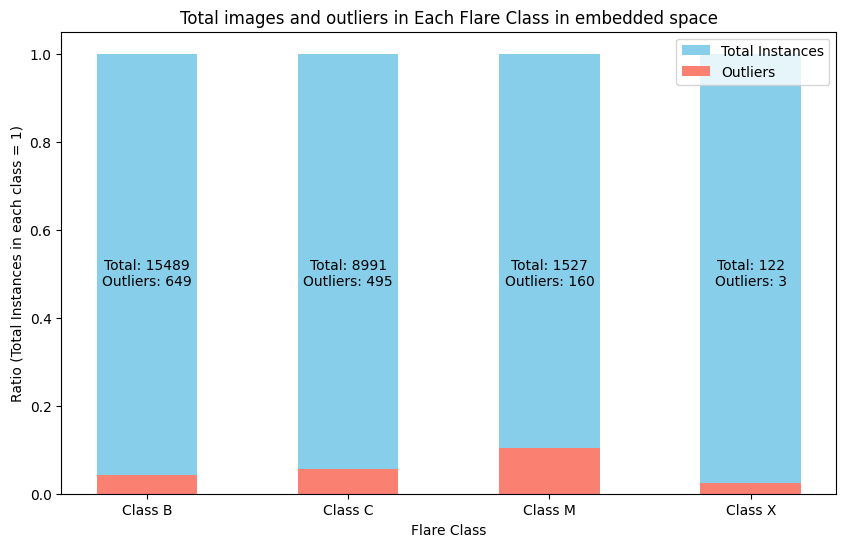

In [51]:
#Finding the outliers
from sklearn.ensemble import IsolationForest
flare_classes = np.zeros(flux_values.shape, dtype=int)

flare_classes[flux_values < 1e-6] = 0  # Class B
flare_classes[(flux_values >= 1e-6) & (flux_values < 1e-5)] = 1  # Class C
flare_classes[(flux_values >= 1e-5) & (flux_values < 1e-4)] = 2  # Class M
flare_classes[flux_values >= 1e-4] = 3  # Class X
# Initialize the Isolation Forest
iso_forest = IsolationForest(contamination=0.05, random_state=42)

# Fit the model and predict outliers
outlier_predictions = iso_forest.fit_predict(embeddings)

# outlier_predictions will be -1 for outliers and 1 for inliers
# Find the indices of the outliers
outlier_indices = np.where(outlier_predictions == -1)[0]

# Extract the outlier embeddings and their flux values
outlier_embeddings = embeddings[outlier_indices]
outlier_flux_values = flux_values[outlier_indices]

outlier_indices = np.where(outlier_predictions == -1)[0]

# Extract the flare classes of the outliers
outlier_classes = flare_classes[outlier_indices]

# Count the number of outliers in each class
unique_classes, outlier_counts = np.unique(outlier_classes, return_counts=True)

# Create a dictionary to map class labels to counts for plotting
class_labels = {0: 'Class B', 1: 'Class C', 2: 'Class M', 3: 'Class X'}
outlier_count_dict = {class_labels[cls]: count for cls, count in zip(unique_classes, outlier_counts)}

print(outlier_count_dict)
import matplotlib.pyplot as plt

# Plot the number of outliers in each class
plt.figure(figsize=(10, 6))
plt.bar(outlier_count_dict.keys(), outlier_count_dict.values(), color='skyblue')
plt.xlabel('Flare Class')
plt.ylabel('Number of Outliers')
plt.title('Number of Outliers in Each Flare Class')
plt.show()

# from sklearn.manifold import TSNE
# import matplotlib.pyplot as plt

# # Reduce dimensions to 2D for visualization using t-SNE
# # tsne = TSNE(n_components=2, random_state=42)
# # embeddings_2d = tsne.fit_transform(embeddings)

# # Plot the embeddings
# plt.figure(figsize=(10, 8))
# plt.scatter(embeddings[:, 5], embeddings[:, 6], c=outlier_predictions, cmap='coolwarm', marker='o')
# plt.title("t-SNE Visualization of Embeddings with Outliers")
# plt.xlabel("Dimension 1")
# plt.ylabel("Dimension 2")
# plt.show()

import numpy as np
import matplotlib.pyplot as plt
from collections import Counter



total_class_counts = Counter(flare_classes)


outlier_class_counts = Counter(outlier_classes)

# Create lists for plotting
classes = ['Class B', 'Class C', 'Class M', 'Class X']
total_counts = [total_class_counts[i] for i in range(4)]
outlier_counts = [outlier_class_counts[i] for i in range(4)]

# Calculate the ratio of outliers to total instances
outlier_ratios = [outlier_counts[i] / total_counts[i] if total_counts[i] != 0 else 0 for i in range(4)]

# Plotting the total instances and outliers as ratios
x = np.arange(len(classes))  # the label locations
width = 0.5  # the width of the bars

fig, ax = plt.subplots(figsize=(10, 6))

# Plot the total instances as a bar of height 1
bars1 = ax.bar(x, [1]*len(classes), width, label='Total Instances', color='skyblue')

# Plot the outliers as a fraction of the total instances
bars2 = ax.bar(x, outlier_ratios, width, label='Outliers', color='salmon')

# Add some text for labels, title, and custom x-axis tick labels, etc.
ax.set_xlabel('Flare Class')
ax.set_ylabel('Ratio (Total Instances in each class = 1)')
ax.set_title('Total images and outliers in Each Flare Class in embedded space')
ax.set_xticks(x)
ax.set_xticklabels(classes)
ax.legend()

# Add counts above the bars
def add_labels(bars, counts, ratios):
    for bar, count, ratio in zip(bars, counts, ratios):
        height = bar.get_height()
        ax.annotate(f'Total: {count}\nOutliers: {int(ratio*count)}',
                    xy=(bar.get_x() + bar.get_width() / 2, height / 2),
                    xytext=(0, 0),  # No offset
                    textcoords="offset points",
                    ha='center', va='center', color='black')

add_labels(bars1, total_counts, outlier_ratios)

plt.show()


3. Training Loop for Contrastive Learning


***Stage 2: Fine-tuning for Classification***
1. Modify the Network for Classification
